**Attention** : this is very short report and main report attached to email

 first we import all we need

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

**1 Data Exploration :**
load the data with fetch_openml 

In [3]:
fashion_mnist = fetch_openml(name="Fashion-MNIST")

# Separate features (X) and labels (y)
X, y = fashion_mnist.data, fashion_mnist.target

print("Feature dimensions (X):", X.shape)
print("Label dimensions (y):", y.shape)

# Convert labels to integers
y = y.astype(int)

print("Minimum pixel value:", X.min().min())
print("Maximum pixel value:", X.max().max())

Feature dimensions (X): (70000, 784)
Label dimensions (y): (70000,)
Minimum pixel value: 0
Maximum pixel value: 255


doing the numerical labels to the dataset represent

In [ ]:
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
# convert numeric labels to string labels
string_labels = [classes[label] for label in y]

set a fix seed for having Reproducibility and show a sample for a class in a grid

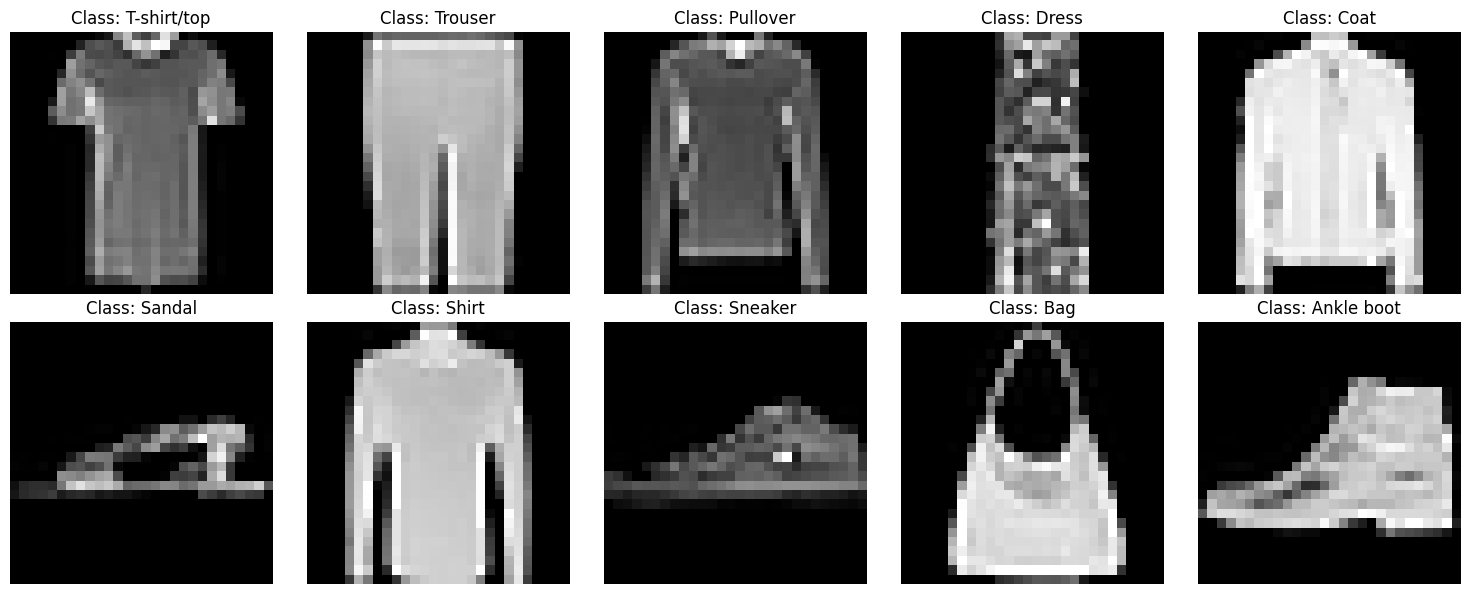

In [ ]:
np.random.seed(22)

classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
                       #1D arrey to 2D
for i, ax in enumerate(axes.ravel()):
                                  # choose only from class y
    idx = np.random.choice(np.where(y == i)[0])
                #access to pd coulmn
    ax.imshow(X.iloc[idx].to_numpy().reshape(28, 28), cmap="gray")
    ax.set_title(f"Class: {classes[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Draw a plot to show the number of each class separately.

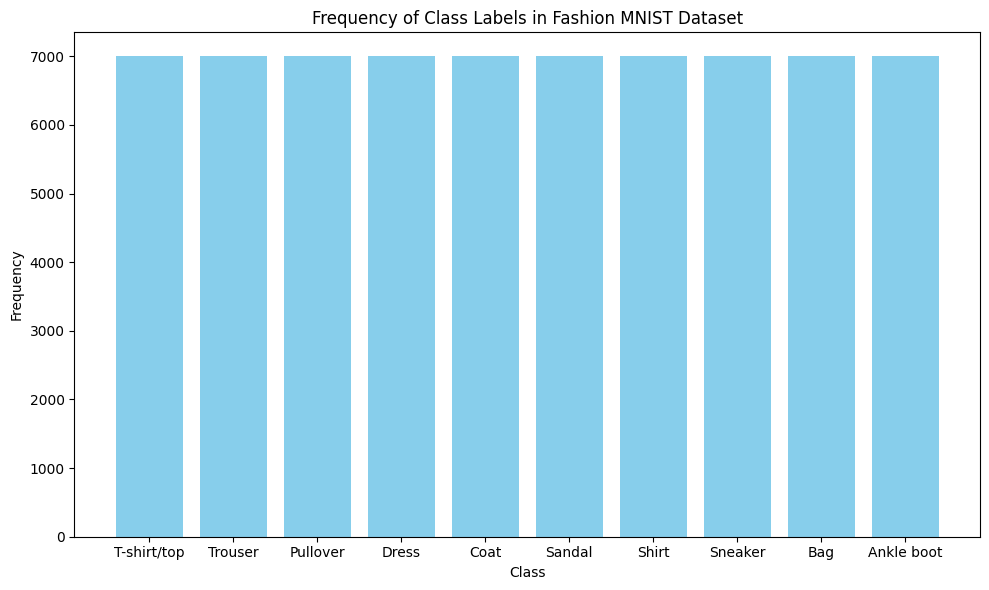

In [5]:
label_counts = pd.Series(y).value_counts().sort_index()

classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10, 6))
plt.bar(classes, label_counts, color="skyblue")
plt.title("Frequency of Class Labels in Fashion MNIST Dataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Data visualization is done using the t-SNE algorithm and choses 100 random data with a fix seed

In [ ]:
sampled_indices = np.hstack([
    np.random.choice(np.where(y == i)[0], size=100, replace=False) for i in range(10)
])
            #access to pd coulmn
X_sampled = X.iloc[sampled_indices].to_numpy()
y_sampled = y[sampled_indices]
                                            #balance local & global naghberhood
tsne = TSNE(n_components=3, random_state=22, perplexity=30)
X_tsne_3d = tsne.fit_transform(X_sampled)


Drow a 3D scatter plot from the reduced data by t-SNE.

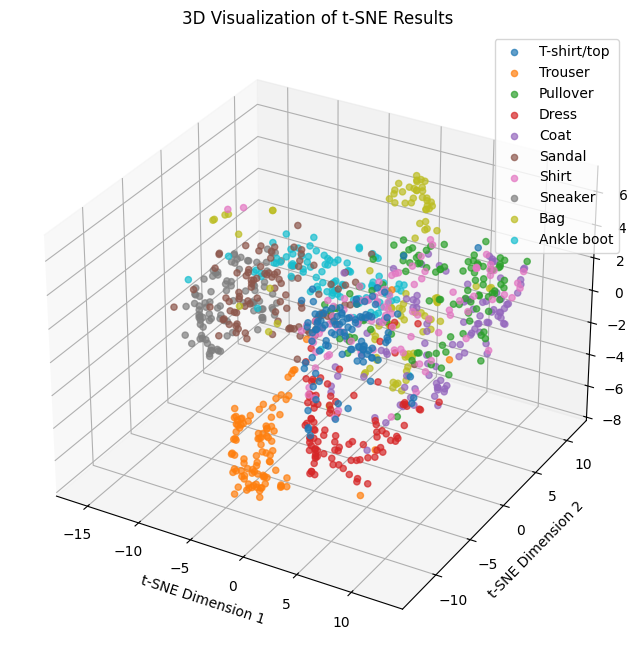

In [ ]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    idx = np.where(y_sampled == i)[0]
    ax.scatter(
        X_tsne_3d[idx, 0],
        X_tsne_3d[idx, 1],
        X_tsne_3d[idx, 2],
        #legend
        label=classes[i],
        alpha=0.7
    )


ax.set_title("3D Visualization of t-SNE Results")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
ax.legend(loc="upper right")
plt.show()

**2 Data Preparation**

Data Splitting: Divide the dataset into three subsets: training, validation, and testing. Use a 70%-15%-15% ratio for these subsets

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=22, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=22, stratify=y_temp
)


print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Testing set: {len(X_test)} samples")

Training set: 49000 samples
Validation set: 10500 samples
Testing set: 10500 samples


create a function for preprocessing data include normalization

In [10]:
def preprocess_data(train_features, val_features, test_features, variance_ratio, y_train, y_val, y_test, scaler_type='minmax', dimensionality_reduction_type='pca'):

    # Ensure inputs are numpy arrays
    train_features = np.array(train_features)
    val_features = np.array(val_features)
    test_features = np.array(test_features)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    # Validate variance_ratio
    if not (0 < variance_ratio <= 1):
        raise ValueError("variance_ratio must be a float between 0 and 1.")

    # Select scaler
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'zscore':
        scaler = StandardScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'maxabs':
        scaler = MaxAbsScaler()
    else:
        raise ValueError("Invalid scaler type. Choose 'minmax', 'robust', 'maxabs', or 'zscore'.")

    # Apply scaling
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)

    # Dimensionality reduction
    if dimensionality_reduction_type == 'pca':

        pca_full = PCA()
        pca_full.fit(train_features_scaled)
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        n_components_pca = np.argmax(cumulative_variance >= variance_ratio) + 1
        dimensionality_reduction = PCA(n_components=n_components_pca)
        train_features_reduced = dimensionality_reduction.fit_transform(train_features_scaled)
        val_features_reduced = dimensionality_reduction.transform(val_features_scaled)
        test_features_reduced = dimensionality_reduction.transform(test_features_scaled)

        print(f"Number of principal components selected: {n_components_pca}")
        print(f"Cumulative variance explained by selected components: {cumulative_variance[n_components_pca - 1]:.2f}")
        
    elif dimensionality_reduction_type == 'lda':
        #number of uniqe class in train set
        n_classes = len(np.unique(y_train))
        if n_classes < 2:
            raise ValueError("LDA requires at least 2 classes. Found only 1 class in y_train.")
        #maximum number of components can extract from lda
        n_components_lda = min(n_classes - 1, train_features.shape[1])
        dimensionality_reduction = LDA(n_components=n_components_lda)
        train_features_reduced = dimensionality_reduction.fit_transform(train_features_scaled, y_train)
        val_features_reduced = dimensionality_reduction.transform(val_features_scaled)
        test_features_reduced = dimensionality_reduction.transform(test_features_scaled)
    else:
        raise ValueError("Invalid dimensionality reduction type. Choose 'pca' or 'lda'.")

   


    return train_features_reduced, val_features_reduced, test_features_reduced, y_train, y_val, y_test

in this cell we write knn from scratch only numpy is allowed.

In [ ]:
def knn_from_scratch(train_features, train_labels, evaluate_features, k, distance_metric='euclidean'):

    batch_size = 100
    predictions = []
    num_evaluate = evaluate_features.shape[0]

    #avoid /0
    epsilon = 1e-5
                         #(start,end,batch size)
    for start_idx in range(0, num_evaluate, batch_size):
        end_idx = min(start_idx + batch_size, num_evaluate)
        batch = evaluate_features[start_idx:end_idx]

        if distance_metric == 'euclidean':                      #add new dim    #featuer dimention
            distances = np.linalg.norm(train_features - batch[:, np.newaxis, :], axis=2)
        elif distance_metric == 'manhattan':
            distances = np.sum(np.abs(train_features - batch[:, np.newaxis, :]), axis=2)
        else:
            raise ValueError(f"Unsupported distance metric: {distance_metric}")

        # Find the nearest k neighbors     (distance Arrey, )         argpartition=>find k smaller index
        nearest_k_indices = np.argpartition(distances, k, axis=1)[:, :k]
        #np.take_along_axis help to select some part of arrey
        nearest_k_distances = np.take_along_axis(distances, nearest_k_indices, axis=1)
        #extract k nearst lable from train_labels
        nearest_k_labels = train_labels[nearest_k_indices]

        # Weighted voting 
        for i in range(batch.shape[0]):
            # weights by Reverse distances
            weights = 1 / (nearest_k_distances[i] + epsilon)
            #each class vote value
            weighted_votes = np.bincount(nearest_k_labels[i], weights=weights, minlength=np.max(train_labels) + 1)
            # return max wighted index
            predicted_label = np.argmax(weighted_votes)
            #if equal : min index selected
            if np.sum(weighted_votes == weighted_votes[predicted_label]) > 1:
                tied_labels = np.where(weighted_votes == weighted_votes[predicted_label])[0]
                predicted_label = np.min(tied_labels)
            #append prediction to predicted_label
            predictions.append(predicted_label)
                                #matrix by only 1 column
    return np.array(predictions).reshape(-1, 1)


In this cell, we call our function and pass the necessary parameters to it.

In [14]:
X_train_pca, X_val_pca, X_test_pca,y_train,y_val,y_test= preprocess_data(X_train, X_val, X_test,0.90,y_train,y_val,y_test,scaler_type='zscore')

k = 5
# accuracy for validation data
start_time = time.time()
val_predictions = knn_from_scratch(X_train_pca, y_train, X_val_pca, k, distance_metric='manhattan')
# % of samples where predictions match with actual labels.
val_accuracy = np.mean(val_predictions.flatten() == y_val.flatten())
print(f"Validation Accuracy: {val_accuracy * 100 :.3f} %")
print(f"Validation Time: {(time.time() - start_time) / 60:.2f} minutes")



start_time = time.time()
test_predictions = knn_from_scratch(X_train_pca, y_train, X_test_pca, k, distance_metric='manhattan')
# accuracy for test data
test_accuracy = np.mean(test_predictions.flatten() == y_test.flatten())
print(f"Test Accuracy: {test_accuracy * 100 :.3f} %")
print(f"Validation Time: {(time.time() - start_time) / 60:.2f} minutes")

Number of principal components selected: 136
Cumulative variance explained by selected components: 0.90
Validation Accuracy: 86.819 %
Validation Time: 6.38 minutes
Test Accuracy: 87.038 %
Validation Time: 6.22 minutes


this for test all method on data 

this is a loop for calculate accuracy in wide range with default methods(pca,euclidean,minmax)

In [ ]:
k_values = [3, 5, 7, 9, 11, 13]
variance_ratios = [0.85,0.9,0.93, 0.96]

results = [] 
#grid search
for variance_ratio in variance_ratios:
    print(f"\nTesting with PCA variance ratio: {variance_ratio}")
    # Preprocess data 
    X_train_reduced, X_val_reduced, X_test_reduced, y_train_reduced, y_val_reduced, y_test_reduced = preprocess_data(
        X_train, X_val, X_test, variance_ratio, y_train, y_val, y_test
    )
    
    for k in k_values:
        print(f"  Testing with k = {k}")
        start_time = time.time()

        # Perform KNN prediction
        y_val_pred = knn_from_scratch(X_train_reduced, y_train_reduced, X_val_reduced, k)
        
        # Compute accuracy
        accuracy = np.mean(y_val_pred.flatten() == y_val_reduced.flatten())
        
        elapsed_time = time.time() - start_time
        print(f"    Accuracy: {accuracy*100:.4f}, Time: {elapsed_time/60:.2f} miniuts")
        
        # Store the result
        results.append({
            'variance_ratio': variance_ratio,
            'k': k,
            'accuracy': accuracy*100,
            'time': elapsed_time
        })

# Display final results
print("\nAll results:")
for result in results:
    print(result)


Testing with PCA variance ratio: 0.85
Number of principal components selected: 43
Cumulative variance explained by selected components: 0.85
  Testing with k = 3
    Accuracy: 85.1524, Time: 3.26 miniuts
  Testing with k = 5
    Accuracy: 85.6000, Time: 3.42 miniuts
  Testing with k = 7
    Accuracy: 85.7905, Time: 3.29 miniuts
  Testing with k = 9
    Accuracy: 85.5048, Time: 3.40 miniuts
  Testing with k = 11
    Accuracy: 85.5810, Time: 3.25 miniuts
  Testing with k = 13
    Accuracy: 85.4952, Time: 3.02 miniuts

Testing with PCA variance ratio: 0.9
Number of principal components selected: 84
Cumulative variance explained by selected components: 0.90
  Testing with k = 3
    Accuracy: 85.8762, Time: 5.48 miniuts
  Testing with k = 5
    Accuracy: 86.1238, Time: 5.41 miniuts
  Testing with k = 7
    Accuracy: 86.2667, Time: 5.31 miniuts
  Testing with k = 9
    Accuracy: 85.7619, Time: 5.34 miniuts
  Testing with k = 11
    Accuracy: 85.8286, Time: 5.40 miniuts

Testing with PCA var

this is a loop for calculate accuracy in wide range with ali methods(pca,lda,euclidean,manhatan,minmax,zscore...)

In [ ]:
import itertools
from sklearn.metrics import accuracy_score

scalers = ['minmax', 'zscore', 'robust', 'maxabs']
dimensionality_reduction_methods = ['pca', 'lda']
distance_metrics = ['euclidean', 'manhattan']
variance_ratios = [0.85, 0.90, 0.92]
k_values = [3, 5, 7]

best_accuracy = 0
best_config = {}


for scaler, dim_red, dist_metric, variance_ratio, k in itertools.product(scalers, dimensionality_reduction_methods, distance_metrics, variance_ratios, k_values):
    try:
        print(f"Testing config: Scaler={scaler}, DimRed={dim_red}, Metric={dist_metric}, Variance={variance_ratio}, k={k}")

        X_train_red, X_val_red, X_test_red, y_train, y_val, y_test = preprocess_data(
            X_train, X_val, X_test, variance_ratio, y_train, y_val, y_test,
            scaler_type=scaler, dimensionality_reduction_type=dim_red
        )

        val_predictions = knn_from_scratch(X_train_red, y_train, X_val_red, k=k, distance_metric=dist_metric)

        val_accuracy = accuracy_score(y_val, val_predictions) * 100
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_config = {
                'scaler': scaler,
                'dimensionality_reduction': dim_red,
                'distance_metric': dist_metric,
                'variance_ratio': variance_ratio,
                'k': k
            }

    except Exception as e:
        print(f"Error for config {scaler}, {dim_red}, {dist_metric}, {variance_ratio}, {k}: {e}")

print("\nBest Configuration:")
print(best_config)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

Testing config: Scaler=minmax, DimRed=pca, Metric=euclidean, Variance=0.85, k=3
Number of principal components selected: 43
Cumulative variance explained by selected components: 0.85
Validation Accuracy: 85.20%
Testing config: Scaler=minmax, DimRed=pca, Metric=euclidean, Variance=0.85, k=5
Number of principal components selected: 43
Cumulative variance explained by selected components: 0.85
Validation Accuracy: 85.60%
Testing config: Scaler=minmax, DimRed=pca, Metric=euclidean, Variance=0.85, k=7
Number of principal components selected: 43
Cumulative variance explained by selected components: 0.85
Validation Accuracy: 85.77%
Testing config: Scaler=minmax, DimRed=pca, Metric=euclidean, Variance=0.9, k=3
Number of principal components selected: 84
Cumulative variance explained by selected components: 0.90
Validation Accuracy: 85.88%
Testing config: Scaler=minmax, DimRed=pca, Metric=euclidean, Variance=0.9, k=5
Number of principal components selected: 84
Cumulative variance explained by s

in this cell Precision ,Recall ,F1 Score , AUC ,Accuracy will be calculated

In [ ]:
# label_binarize necessery for AUC(each class has 1 column)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
test_predictions = knn_from_scratch(X_train_pca, y_train, X_test_pca, k)
num_classes = len(np.unique(y_train))
precisions = []
recalls = []
f1_scores = []
auc_scores = []

for i in range(num_classes):
                               #real lable class i,
    precision = precision_score(y_test_bin[:, i], test_predictions.flatten() == i)
    recall = recall_score(y_test_bin[:, i], test_predictions.flatten() == i)
    f1 = f1_score(y_test_bin[:, i], test_predictions.flatten() == i)
    auc = roc_auc_score(y_test_bin[:, i], test_predictions.flatten() == i)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

# Create a DataFrame to show better
results_df = pd.DataFrame({
    "Class": [f"class {i}" for i in range(num_classes)],
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores,
    "AUC": auc_scores
})

print(results_df)


     Class  Precision    Recall  F1 Score       AUC
0  class 0   0.805160  0.861905  0.832567  0.919365
1  class 1   0.988406  0.974286  0.981295  0.986508
2  class 2   0.785857  0.751429  0.768257  0.864339
3  class 3   0.900892  0.865714  0.882953  0.927566
4  class 4   0.729991  0.790476  0.759031  0.878995
5  class 5   0.980493  0.909524  0.943676  0.953757
6  class 6   0.675299  0.645714  0.660175  0.805608
7  class 7   0.931455  0.944762  0.938061  0.968519
8  class 8   0.981678  0.969524  0.975563  0.983757
9  class 9   0.918092  0.971429  0.944007  0.980899


in this cell ROC curve will be plotted

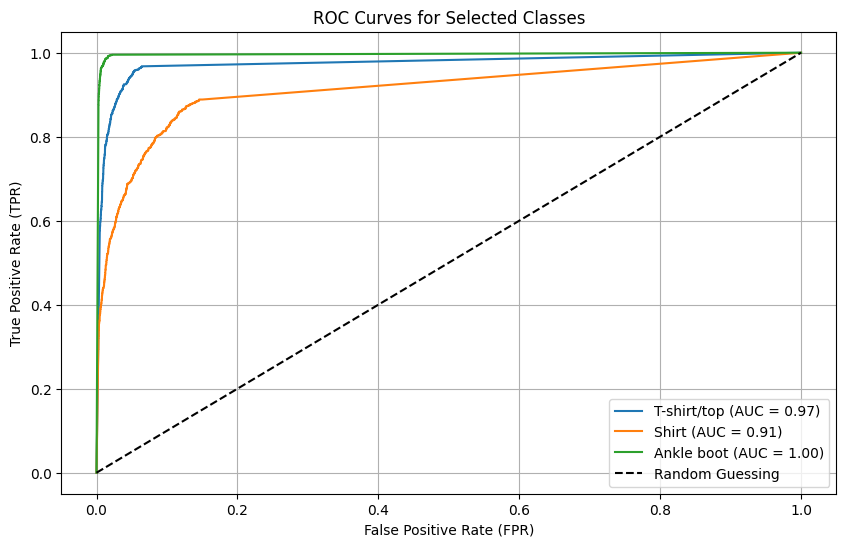

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def knn_probabilities(train_features, train_labels, evaluate_features, k):

    batch_size = 100
    num_classes = len(np.unique(train_labels))
    num_evaluate = evaluate_features.shape[0]
    # a matrix that stores the probability of each sample belonging to each class.
    probabilities = np.zeros((num_evaluate, num_classes))
    epsilon = 1e-5 

    for start_idx in range(0, num_evaluate, batch_size):
        end_idx = min(start_idx + batch_size, num_evaluate)
        batch = evaluate_features[start_idx:end_idx]

        distances = np.linalg.norm(train_features - batch[:, np.newaxis, :], axis=2)
        # Find the nearest k neighbors     (distance Arrey, )         argpartition=>find k smaller index
        nearest_k_indices = np.argpartition(distances, k, axis=1)[:, :k]
        # np.take_along_axis help to select some part of arrey
        nearest_k_distances = np.take_along_axis(distances, nearest_k_indices, axis=1)
        # extract k nearst lable from train_labels
        nearest_k_labels = train_labels[nearest_k_indices]

        # weights to each class Separately
        for i in range(batch.shape[0]):
            # weights by Reverse distances
            weights = 1 / (nearest_k_distances[i] + epsilon)
            weighted_votes = np.zeros(num_classes)
            ## For each class calculates sum of weights of the neighbors that class and stores it in the weighted_votes array.
            for cls in range(num_classes):
                # create boolean mask for class
                class_mask = (nearest_k_labels[i] == cls)
                #sum weights for each class Separately
                weighted_votes[cls] = weights[class_mask].sum()
            # weights noramalization and save probabilities for ecah
            probabilities[start_idx + i] = weighted_votes / weighted_votes.sum()

    return probabilities

# Binarize test labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

# Get probabilities for test data
test_probabilities = knn_probabilities(X_train_pca, y_train, X_test_pca, k)


# Plot ROC curves
# calss id that we want plot
classes_to_plot = [0, 6, 9]
class_names = ["T-shirt/top", "Shirt", "Ankle boot"]
plt.figure(figsize=(10, 6))

#Drow plot for each class in classes_to_plot
for cls_idx, cls in enumerate(classes_to_plot):
    #calculate FPR (False Positive Rate) & TPR (True Positive Rate)
    fpr, tpr, _ = roc_curve(y_test_bin[:, cls], test_probabilities[:, cls])
    # calculate AUC
    roc_auc = auc(fpr, tpr)
    #Drow plot          #legend                         #AUC for each class
    plt.plot(fpr, tpr, label=f"{class_names[cls_idx]} (AUC = {roc_auc:.2f})")

## Plot styling
# Drow Random Guessing Line (0,0) to (1,1)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Selected Classes")
plt.legend(loc="lower right")
plt.grid()
plt.show()


in this cell Confusion Matrix will be plotted

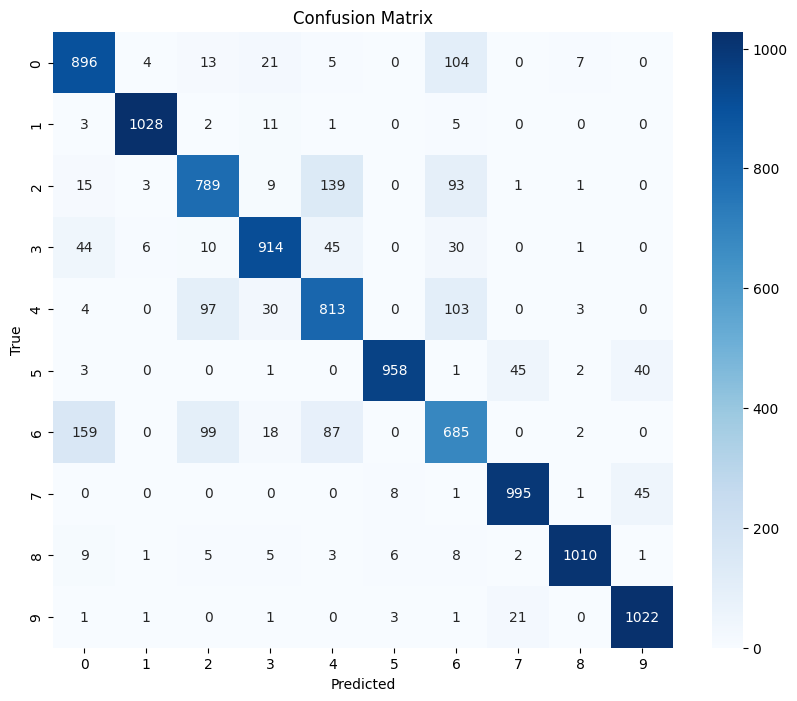


Summary of Metrics:
            Metric   Value
0         Accuracy  86.76%
1  Macro Precision  86.90%
2     Macro Recall  86.76%
3   Macro F1 Score  86.79%
4        Macro AUC    0.97


In [ ]:
conf_matrix = confusion_matrix(y_test, test_predictions.flatten())
plt.figure(figsize=(10, 8))
                        # Each cell show number of its values.     X labels                          Y labels
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Precision, Recall, F1-Score, و AUC
overall_accuracy = accuracy_score(y_test, test_predictions.flatten())
report = classification_report(y_test, test_predictions.flatten(), output_dict=True)
precision_macro = report["macro avg"]["precision"]
recall_macro = report["macro avg"]["recall"]
f1_macro = report["macro avg"]["f1-score"]
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
                                                                          # One-vs-Rest
macro_auc = roc_auc_score(y_test_bin, test_probabilities, average="macro", multi_class="ovr")

# Result in a table
metrics = {
    "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1 Score", "Macro AUC"],
    "Value": [
        f"{overall_accuracy * 100:.2f}%",
        f"{precision_macro * 100:.2f}%",
        f"{recall_macro * 100:.2f}%",
        f"{f1_macro * 100:.2f}%",
        f"{macro_auc:.2f}",
    ],
}
metrics_table = pd.DataFrame(metrics)

print("\nSummary of Metrics:")
print(metrics_table)